# 1 Background Information

When an analyst determines the price of a house, they need to consider many factors, including location, size, and construction quality. Luckily, machine learning models exist to do the work for them. In this project, I trained and evaluated regression models to predict the prices of houses. I used a dataset from OpenIntro of 2930 houses in Ames, Iowa with 79 predictors. To download the dataset and read the predictor descriptions, [click here](https://www.openintro.org/data/index.php?data=ames). 

# 2 Import Libraries and Data

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

sns.set_theme()

In [29]:
# Use the Order column (unique identifier for each house) as the row index
houses_data = pd.read_csv('ames_houses_data.csv', index_col="Order")

X_houses_data = houses_data.drop("price", axis=1)
y_houses_data = houses_data.price
X_train, X_test, y_train, y_test = train_test_split(X_houses_data, y_houses_data, test_size=0.2, random_state=42)

print("Training dataset size: ", X_train.shape)
print("Test dataset size: ", X_test.shape)

Training dataset size:  (2344, 80)
Test dataset size:  (586, 80)


# 3 Data Procesesing

## 3.1 Removing categorical predictors

To simplify the analysis, I only used quantitative predictors.

In [30]:
houses_data = houses_data.select_dtypes(include="number")
# Manually remove categorical columns encoded with integers
houses_data.drop(columns=["MS.SubClass", "Mo.Sold", "PID"], inplace=True) 
print(f"There are {len(houses_data.columns)} predictors left:\n",
      list(houses_data.columns), sep="")

There are 35 predictors left:
['area', 'price', 'Lot.Frontage', 'Lot.Area', 'Overall.Qual', 'Overall.Cond', 'Year.Built', 'Year.Remod.Add', 'Mas.Vnr.Area', 'BsmtFin.SF.1', 'BsmtFin.SF.2', 'Bsmt.Unf.SF', 'Total.Bsmt.SF', 'X1st.Flr.SF', 'X2nd.Flr.SF', 'Low.Qual.Fin.SF', 'Bsmt.Full.Bath', 'Bsmt.Half.Bath', 'Full.Bath', 'Half.Bath', 'Bedroom.AbvGr', 'Kitchen.AbvGr', 'TotRms.AbvGrd', 'Fireplaces', 'Garage.Yr.Blt', 'Garage.Cars', 'Garage.Area', 'Wood.Deck.SF', 'Open.Porch.SF', 'Enclosed.Porch', 'X3Ssn.Porch', 'Screen.Porch', 'Pool.Area', 'Misc.Val', 'Yr.Sold']


## 3.2 Handling missing data

In [31]:
missing_data_count = houses_data.isnull().sum()
missing_data_percent = houses_data.isnull().sum() / len(houses_data) * 100
missing_data = pd.DataFrame({
    'No. of missing values': missing_data_count,
    'Percentage of values missing': missing_data_percent
})
missing_data = missing_data[missing_data.loc[:,'No. of missing values'] > 0]
missing_data.sort_values(by='Percentage of values missing', ascending=False, inplace=True)
missing_data.head(3)

,No. of missing values,Percentage of values missing
Lot.Frontage,490,16.723549
Garage.Yr.Blt,159,5.426621
Mas.Vnr.Area,23,0.784983


- **Lot.Frontage**: The distance between the house and the front road. I will impute the missing values with the average value in the training dataset.
- **Garage.Yr.Blt**: The year the garage was built. Since it is highly correlated with **YearBuilt** (r = 0.826, see the correlation map below), I will impute the missing values with the **YearBuilt** values. 

For the remaining predictors, the number of missing values are small so I simply deleted them.

In [32]:
houses_data.loc[:,"Lot.Frontage"] = (houses_data.loc[:,"Lot.Frontage"].
                                     fillna(X_train.loc[:,"Lot.Frontage"].mean()))
houses_data.loc[:,"Garage.Yr.Blt"] = (houses_data.loc[:,"Garage.Yr.Blt"].
                                      fillna(houses_data.loc[:,"Year.Built"]))

# Drop all rows with missing values
X_train = houses_data[:len(X_train)].dropna()
y_train = houses_data[:len(y_train)].dropna()
X_test = houses_data[len(houses_data)-len(X_test):].dropna()
y_test = houses_data[len(houses_data)-len(y_test):].dropna()

print("No. of missing values remaining is", 
      sum(X_train.isnull().sum()) + sum(X_test.isnull().sum()))
print("New training set size:", X_train.shape)
print("New test set size:", X_test.shape)

No. of missing values remaining is 0
New training set size: (2322, 35)
New test set size: (582, 35)


In [33]:
print(y_train)

       area   price  Lot.Frontage  ...  Pool.Area  Misc.Val  Yr.Sold
Order                              ...                              
1      1656  215000    141.000000  ...          0         0     2010
2       896  105000     80.000000  ...          0         0     2010
3      1329  172000     81.000000  ...          0     12500     2010
4      2110  244000     93.000000  ...          0         0     2010
5      1629  189900     74.000000  ...          0         0     2010
...     ...     ...           ...  ...        ...       ...      ...
2340   1714  318000     60.000000  ...          0         0     2006
2341   1826  319000     69.000000  ...          0         0     2006
2342   2000  470000     90.000000  ...          0         0     2006
2343   1621  202500     91.000000  ...          0       400     2006
2344   2183  229000     69.207586  ...          0         0     2006

[2322 rows x 35 columns]


# 4 Exploratory Data Analysis

## 4.1 Distribution of the house prices (the response)

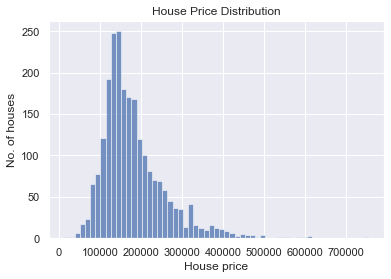

In [34]:
sns.histplot(y_train.loc[:,"price"])
plt.title("House Price Distribution")
plt.xlabel("House price")
plt.ylabel("No. of houses")
plt.show()

The distribution of house prices is positively skewed due to the presence of a few very expensive houses. 

## 4.2 Correlations between variables

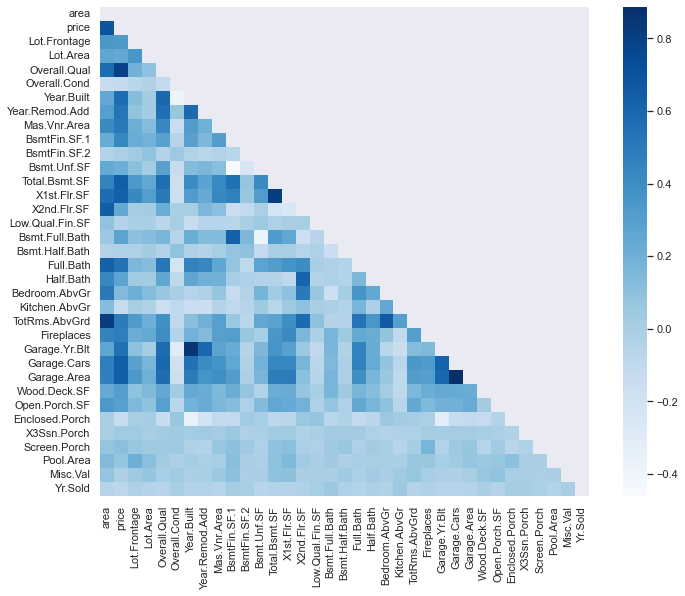

In [41]:
correlation_matrix = pd.concat([X_train, y_train]).corr()
lower_triangle_mask = np.tril(np.ones(correlation_matrix.shape), k = -1).astype(bool)
# Replace all values above the lower triangle with NaN
correlation_matrix = correlation_matrix.where(lower_triangle_mask)

with sns.axes_style("dark"):
    f, ax = plt.subplots(figsize=(12, 9))
    sns.heatmap(correlation_matrix, cmap="Blues", square=True);

In [43]:
most_positive = correlation_matrix.loc[:, "price"].sort_values(ascending=False)[0:5]
print(f"The {len(most_positive)} predictors that were most positively correlated with the house price were:\n", 
      most_positive, "\n", sep="")

most_negative = correlation_matrix.loc[:, "price"].sort_values(ascending=True)[0:1]
print(f"The predictor that was most negatively correlated with the house price was:\n", 
       most_negative, sep="")

The 5 predictors that were most positively correlated with the house price were:
Overall.Qual     0.799986
Garage.Cars      0.644626
Total.Bsmt.SF    0.640728
Garage.Area      0.635868
X1st.Flr.SF      0.630240
Name: price, dtype: float64

The predictor that was most negatively correlated with the house price was:
Enclosed.Porch   -0.129684
Name: price, dtype: float64


- **OverallQual**: Quality of the construction materials and workmanship on a scale of 1 to 10. 
- **GrLivArea**: The total living area above the ground. 
- **GarageCars**: No. of cars that can fit in the garage. 
- **GarageArea**: Area of the garage. (Notice that is is highly correlated with GarageCars). 
- **TotalBsmtSF**: The area of the basement.

There were no quantitative predictors that were significantly negatively correlated with the house price.